## Simulación de la ecuación de onda
Vamos a intentar simular la ecuación de onda

$$ \frac{\partial^2}{\partial^2 t}u(x, t) = c^2 \frac{\partial^2}{\partial x^2}u(x, t) $$ 


Usando la funcion tradicional $d_t(x)$ y las propiedades de la Transformada de Fourier con respecto a la convolución. Dejando nuestra ecuación de la siguiente forma 

$$ \frac{\partial^2 }{\partial^2 t}\hat{u}(\omega, t) = c^2 \cdot \hat{d_t}(\omega) \cdot \hat{u}(\omega, t) $$


Donde cada punto $\omega$ se puede interpretar como su propia ecuación diferencial de primer orden. Esto es lo que usarmeos para resolver este problema.

Ahora, para resolver esta ecuación diferencial, que es de segundo orden, podemos resolverla simplemente así o podemos simplificarlo a un sistema de ecuaciones diferenciales de primer orden, dejando el sistema

$$ \begin{cases} 
    \frac{\partial}{\partial t}\hat{u}(\omega, t) = \hat{v}(\omega, t) \\
    \frac{\partial}{\partial t}\hat{v}(\omega, t) = c^2 \cdot \hat{d_t}(\omega) \cdot \hat{u}(\omega, t)
\end{cases} $$

### Seteando el espacio
Vamos a crear el espacio, su transformación y la transformación de la aproximación tradicional.

In [1]:
import numpy as np
import scipy as sc

from matplotlib import pyplot as plt
from matplotlib import cm as cm

In [2]:
radio = 100
cantidadPuntos = 1001
x = np.linspace(-radio, radio, cantidadPuntos)
dx = (2 * radio) / (cantidadPuntos - 1)

campoU = np.zeros(len(x))
campoU = 1 / np.cosh(x)

campoV = np.zeros(len(x))
centro = int(np.floor(cantidadPuntos / 2))
desviacion = 50
campoV[centro - desviacion : centro + desviacion] = -1
campoV = campoV * np.sin(x * 2 * np.pi / 20)

cantidadCampos = 2
campos = np.zeros([cantidadCampos, cantidadPuntos])
campos[0] = campoU
campos[1] = campoV

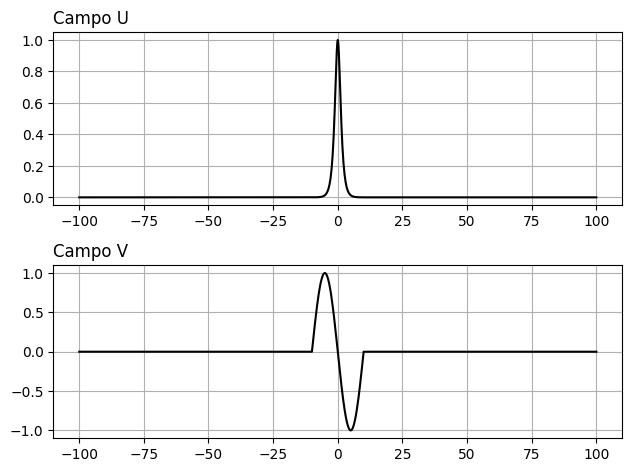

In [3]:
plt.figure()

plt.subplot(2, 1, 1)
plt.plot(x, campos[0], 'k-')
plt.grid(True)
plt.title('Campo U', loc = 'left')
plt.tight_layout(pad=1.0)

plt.subplot(2, 1, 2)
plt.plot(x, campos[1], 'k-')
plt.grid(True)
plt.title('Campo V', loc = 'left')
plt.tight_layout(pad=1.0)

plt.show()

Usando como constate $c^2 = 100$ y un delta de tiempo $dt = 0.001$

In [4]:
c = 10
dt = 0.0001

In [5]:
def AproximacionTradicional(x, dx, orden):
    largo = len(x)
    puntoMedio = int(np.floor(largo / 2))

    y = np.zeros(largo)
    valores = np.array([210, -120, 45, -10, 1])
    #valores = np.array([-56, 28, -8, 1])
    sumaTotal = np.sum(valores)

    for i, valor in enumerate(valores):
        valor /= 2 * (i + 1) * sumaTotal
        y[puntoMedio + i + 1] = -valor
        y[puntoMedio - i - 1] = valor

    y = np.fft.fft(np.fft.ifftshift(y / dx))
    return (y) ** orden

In [6]:
kernel2D = AproximacionTradicional(x, dx, 2)

### Simular

In [7]:
def FuncionIteracion(tiempo, estado):
    return [
        estado[1],
        c**2 * kernel2D * estado[0]
    ]

